In [1]:
import sys
print(sys.path)

['/home/emerson/miniconda3/lib/python310.zip', '/home/emerson/miniconda3/lib/python3.10', '/home/emerson/miniconda3/lib/python3.10/lib-dynload', '', '/home/emerson/.local/lib/python3.10/site-packages', '/home/emerson/miniconda3/lib/python3.10/site-packages']


In [ ]:
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#print(dir(sam2))
from sam2.sam2_image_predictor import SAM2ImagePredictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor

#from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os
from config import topview_vec, sideview_vec, tcp_X_offset, tcp_Y_offset, tcp_Z_offset, n_depth_samples, vit_thresh, tower, collect_data
sys.path.append("../")
sys.path.append("/home/emerson/THESIS/magpie_control/src")
import numpy as np
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2
from Observation import observation

import time
import os

import random
from openai import OpenAI

from control_scripts import goto_vec, get_pictures, get_frames
from gpt_planning import get_gpt_next_instruction, print_json
from APIKeys import API_KEY


ImportError: cannot import name 'data_collection' from 'config' (/home/emerson/THESIS/FoundationModelBlockStacking/config.py)

In [3]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
print(f"starting robot from nb")
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold=vit_thresh, cpu_override=False)
label_vit.model.eval()
#print(dir(label_vit.model))
print(f"{label_vit.model.device=}")

sam_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
print(f"{sam_predictor.model.device=}")

client = OpenAI(
        api_key= API_KEY,
    )


starting robot from nb
Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
label_vit.model.device=device(type='cuda', index=0)
sam_predictor.model.device=device(type='cuda', index=0)


In [4]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [5]:
def topview_pick_place_Observations(UR_Interface, rs_wrapper, pick_str, place_str, display= False):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    pick_obs, place_obs = observation(str_label = pick_str) , observation(str_label=place_str)
    pick_obs.update_observation(rs_wrapper, label_vit, sam_predictor, topview_vec, display=True)
    place_obs.update_observation(rs_wrapper, label_vit, sam_predictor, topview_vec, display=True)
    return pick_obs, place_obs



In [6]:
def pick(UR_interface, obs):
    X, Y, Z = obs.ImgFrameWorldCoord
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset - obs.sidelength

    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)
    #print(goal_vec)
    #UR_interface.disconnect()
    #input()

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)
    return success

#pick(myrobot, myrs, pick_bb, display = True)

In [7]:
def place(UR_interface, obs):
    X, Y, Z = obs.ImgFrameWorldCoord
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset
    #if "table" in bb["strlabel"]:
    #    new_X += random.uniform(-0.05, 0.05)
    #    new_Y += random.uniform(0, 0.05)

    

    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)


    UR_interface.open_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)

    return success


No LLM PLANNING

In [8]:
"""
#myrobot.stop()
#myrs.disconnect()
#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
temp_tower = [ "yellow block", "blue block", "green block"]#, "green block"]
#tower = ["yellow block", "red block"]
for i in range(0, len(temp_tower)-1):
     pick_str = temp_tower[i+1]
     place_str = temp_tower[i]
     pick_obs, place_obs = topview_pick_place_Observations(myrobot, myrs, pick_str, place_str, display=True)
     pick(myrobot, pick_obs)
     place(myrobot, place_obs)

"""

'\n#myrobot.stop()\n#myrs.disconnect()\n#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]\ntemp_tower = [ "yellow block", "blue block", "green block"]#, "green block"]\n#tower = ["yellow block", "red block"]\nfor i in range(0, len(temp_tower)-1):\n     pick_str = temp_tower[i+1]\n     place_str = temp_tower[i]\n     pick_obs, place_obs = topview_pick_place_Observations(myrobot, myrs, pick_str, place_str, display=True)\n     pick(myrobot, pick_obs)\n     place(myrobot, place_obs)\n\n'

YES LLM PLANNING

In [9]:
def create_next_directory(base_dir):
    # List all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Extract the numeric part of the directory names (e.g., 'run_0', 'run_1')
    subdirectories = [d for d in subdirectories if d.startswith('run_')]
    subdirectories = [int(d.split('_')[1]) for d in subdirectories if d.split('_')[1].isdigit()]
    
    # If there are no subdirectories, start from 0, else find the max and add 1
    next_dir = max(subdirectories, default=-1) + 1

    # Create the new directory with the name 'run_<next_dir>'
    next_dir_path = os.path.join(base_dir, f"run_{next_dir}")
    os.makedirs(next_dir_path, exist_ok=True)
    
    return next_dir_path

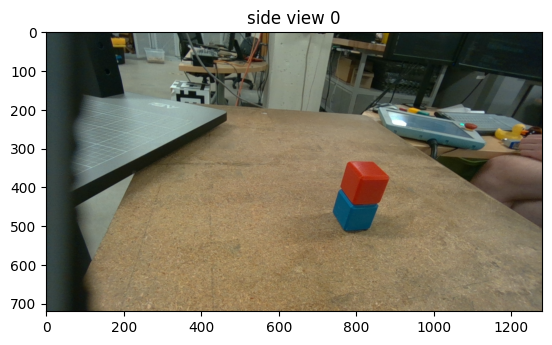

state={
    "objects": [
        "table",
        "red block",
        "blue block"
    ],
    "object_relationships": [
        [
            "red block",
            "blue block"
        ],
        [
            "blue block",
            "table"
        ]
    ]
}
next instruction={
    "current state": "Red block is on top of blue block, and blue block is on top of the table.",
    "done": false,
    "explanation": "To achieve the desired configuration, the red block needs to be at the base with the blue block on top. Currently, the red block is on top of the blue block. We need to reverse their positions.",
    "pick": "red block",
    "place": "table",
    "end state": "Red block is on the table, and blue block is on the table."
}
plan=[
    [
        "1",
        {
            "current state": "Red block is on the table, and blue block is on the table.",
            "done": false,
            "explanation": "Now that both blocks are on the table, we can place the blue block on top

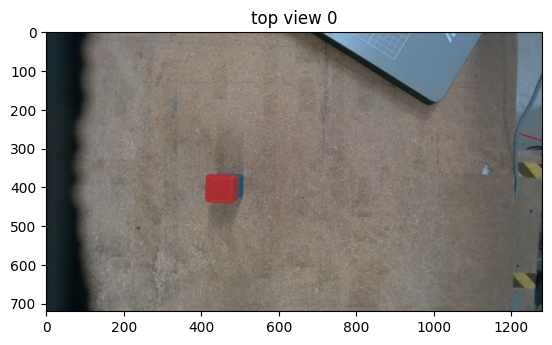

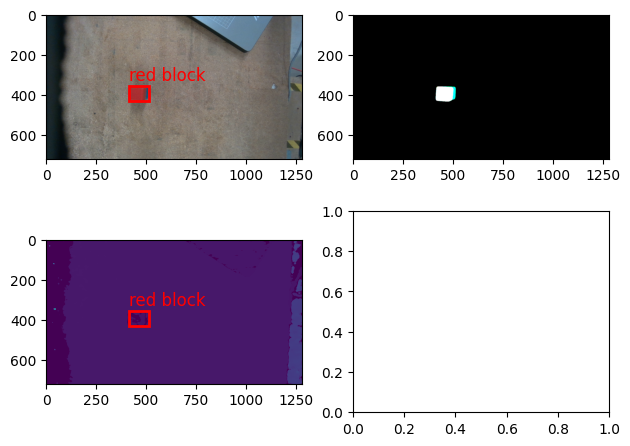

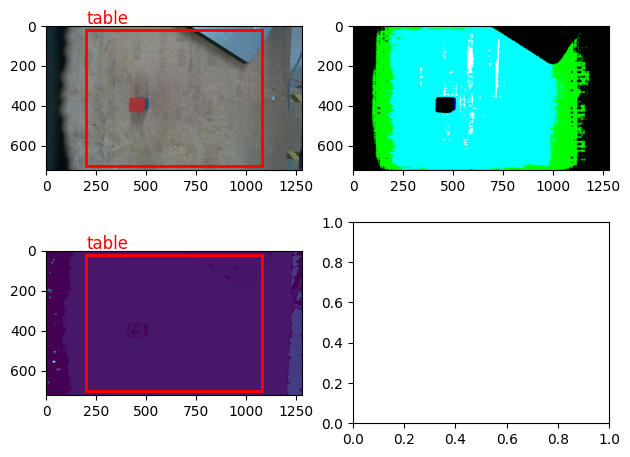

Camera Frame Coordinates of Block: X=-0.0943966880440712, Y=0.020764321088790894, Z=0.3483833074569702

Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Camera Frame Coordinates of Block: X=0.004070065449923277, Y=0.002558786189183593, Z=0.4251999855041504

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


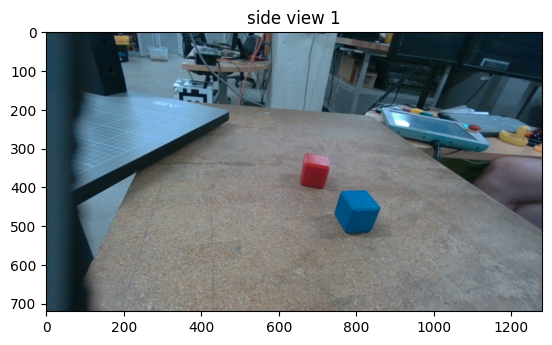

state={
    "objects": [
        "table",
        "red block",
        "blue block"
    ],
    "object_relationships": [
        [
            "red block",
            "table"
        ],
        [
            "blue block",
            "table"
        ]
    ]
}
next instruction={
    "current state": "Red block is on the table, and blue block is on the table.",
    "done": false,
    "explanation": "Now that both blocks are on the table, we can place the blue block on top of the red block to achieve the desired configuration.",
    "pick": "blue block",
    "place": "red block",
    "end state": "Red block is on the table, and blue block is on top of the red block."
}
plan=[
    [
        "1",
        {
            "current state": "Red block is on the table, and blue block is on top of the red block.",
            "done": true,
            "explanation": "The desired configuration is achieved with the red block at the base and the blue block on top.",
            "pick": "",
          

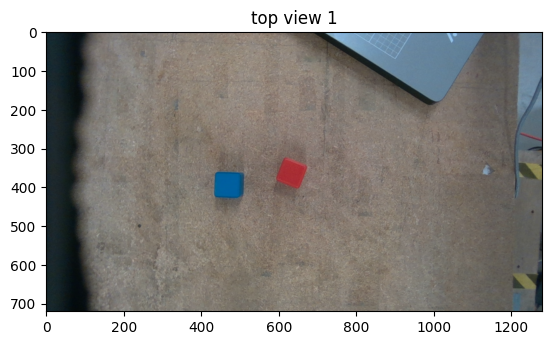

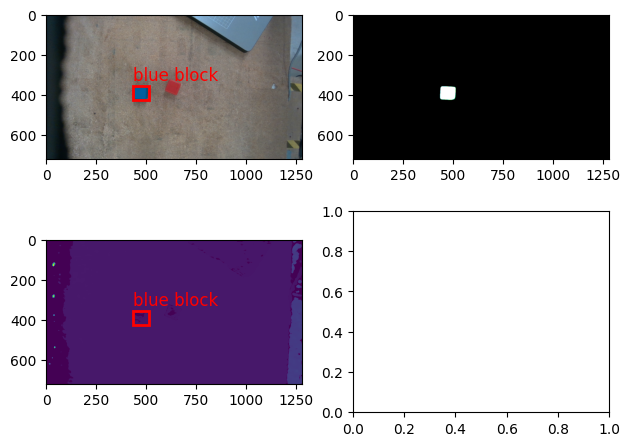

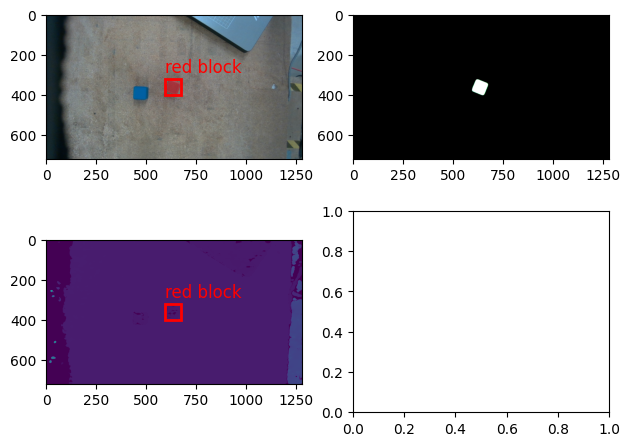

Camera Frame Coordinates of Block: X=-0.09964743256568909, Y=0.020940756425261497, Z=0.3928999900817871

Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Camera Frame Coordinates of Block: X=0.0006608097464777529, Y=0.00235011731274426, Z=0.3905249834060669

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


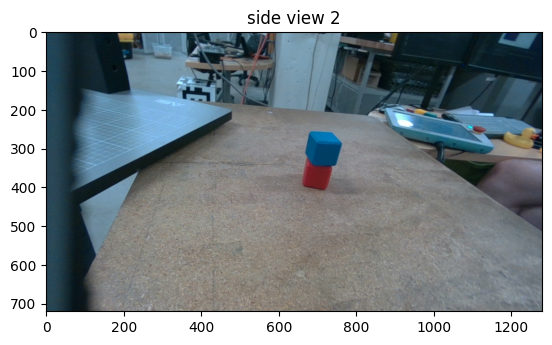

state={
    "objects": [
        "table",
        "blue block",
        "red block"
    ],
    "object_relationships": [
        [
            "blue block",
            "red block"
        ],
        [
            "red block",
            "table"
        ]
    ]
}
next instruction={
    "current state": "Red block is on the table, and blue block is on top of the red block.",
    "done": true,
    "explanation": "The desired configuration is achieved with the red block at the base and the blue block on top.",
    "pick": "",
    "place": "",
    "end state": "Red block is at the base with the blue block on top, forming the correct tower."
}
plan=[]
instruction_usr_prompt="Give me the next step so the blocks are stacked with the red block at the base of the tower\nthe blue block on the red block.The objects are currently stacked as follows:\n   blue block is on top of red block.\n   red block is on top of table.\n\nup until this point the actions you took in order were:\n   {'current sta

In [ ]:

#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
#tower = tower.reverse()
n_attempts = 2*len(tower)
Done = 0
i = 0
top_dir = "./data_collection/"
os.makedirs(top_dir, exist_ok=True)
save_dir = create_next_directory(top_dir)
action_history = []
previous_plan = []
collect_data = True

while(not Done and i < n_attempts):
    interation_output_dir = os.path.join(save_dir, f"step {i}")
    os.makedirs(interation_output_dir, exist_ok=True)
    goto_vec(myrobot, sideview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"side view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "sideview.png"), rgb_img)

    (state_resp, state, state_sys_prompt, state_usr_promot), (instruction_resp, next_instruction, future_instructions, instruction_sys_prompt, instruction_usr_prompt) = get_gpt_next_instruction(client, rgb_img, tower, action_history, previous_plan)

    # data_collection
    if (collect_data):
        with open(os.path.join(interation_output_dir, "instruction.txt"), "w") as file: 
            state_str = print_json(state, name="state")
            file.write(f"{state_str}\n")

            next_instruction_str = print_json(next_instruction, "next instruction")
            file.write(f"{next_instruction_str}")

            instruction_plan_str = print_json(future_instructions, name="plan")
            file.write(f"{instruction_plan_str}")

            file.write(f"{state_sys_prompt=}\n")
            file.write(f"{state_usr_promot=}\n")
            file.write(f"{instruction_sys_prompt=}\n")
            file.write(f"{instruction_usr_prompt=}\n")
            print(f"{instruction_usr_prompt=}")


    action_history.append(next_instruction)
    previous_plan = future_instructions
    Done = int(next_instruction["done"])

    if Done:
        break


    pick_str= next_instruction['pick']
    place_str= next_instruction['place']
    goto_vec(myrobot, topview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"top view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "topview.png"), rgb_img)
    pick_obs, place_obs = topview_pick_place_Observations(myrobot, myrs, pick_str, place_str, display=True)
    pick(myrobot, pick_obs)
    place(myrobot, place_obs)
    i += 1
